Ecopetrol - Color.svg

# **Prueba de Ciencia de Datos**

## **Contexto de negocio**
Una entidad financiera tiene unas reglas de negocio bastante estrictas para la entrega de tarjetas de crédito, por lo que en la actualidad está rechazando gran cantidad de clientes, situación que está afectando las metas del área comercial.

La empresa necesita construir un modelo predictivo que permita estimar la probabilidad de que un cliente pagué o no un crédito.

Se les hace entrega de un archivo train.parquet con información histórica de los clientes que han sido aprobados y la clasificación de su comportamiento de pago en los 6 meses posterior a la entrega de la tarjeta, marcando como malo si presentó mora mayor a 60 días, y bueno en el caso contrario. Se trata de data estructurada tabular donde cada fila representa un crédito, y cada columna una variable característica del crédito, con una columna particular final que indica si el crédito presentó problemas de pago o no.

Se espera que entrene al menos 2 modelos predictivos de clasificación de diferentes familias (familias de referencia: regresión logística regularizada, SVM con diferentes kernels, Random Forest, XGBoost, Redes Neuronales), precedidos por diferentes procesos de transformación (normalizaciones, imputación, feature engineering, dummificación, PCA, LDA, selección de features). En caso de tener otra metodología fuera de las familias propuestas, se podrá incluir pero se deberá justificar el porque se puede utilizar y sus ventajas respecto de las otras.

La evaluación de la calidad de los flujos de modelos predictivos se debe estimar utilizando la métrica de ROC AUC.

Expliquen sus ideas, el por qué realizan las acciones, y comenten los resultados obtenidos; se espera mucho más que unos bloques de código.
La toma de decisiones sobre los datos se debe hacer considerando el contexto del problema y de los datos, no se puede ver todo solamente desde los ojos de los datos, sino también considerar el negocio.

Una vez escogido el mejor flujo de modelo, predecir los individuos del archivo test.parquet, y crear un archivo CSV "puntajes_test.csv" con únicamente dos columnas "id_cliente" y "bad", con los identificadores y puntaje de probabilidad de que un cliente sea malo, , tal como se muestra en el siguiente ejemplo:

id_cliente,bad

42010,0.551

42011,0.326

### **Descripción de los campos**
Cada fila contiene la información de un préstamo histórico a un cliente, descrito en términos de las siguientes variables:

- **edad:** edad en años de quién recibió el préstamo.
- **nro_hijos:** número de hijos de quién recibió el préstamo. El valor de -1 implica ninguno.
- **n_vehiculos:** número de carros de quién recibió el préstamo. El valor de -1 implica ninguno.
- **ingreso_bruto:** ingresos devengados por quién recibió el préstamo.
- **ingreso_liquido:** ingresos liquidos disponibles de quién recibió el préstamo.
- **consumo:** deuda de créditos de consumo.
- **hipot:** deuda hipotecaria.
- **comercial:** deuda de créditos comerciales.
- **disponible:** linea de crédito disponible.
- **dd_aldia_y_menor30:** monto de deuda (total) que el cliente tiene al día o con mora menor a 30 días.
- **dd_impaga_30_90:** monto de deuda (total) que el cliente tiene con mora entre 30 y 90 días.
- **dd_impaga_90_180:** monto de deuda (total) que el cliente tiene con mora entre 90 y 180 días.
- **dd_impaga_180_3anos:** monto de deuda (total) que el cliente tiene con mora entre 180 días y 3 años.
- **estado_civil:** variable categórica con el estado civil de quién recibió el préstamo. Los valores son:
    - 0 (Casado(a))
    - 1 (Sin información)
    - 2 (Separado(a))
    - 3 (Soltero(a))
    - 4 (Viudo(a))
- **nivel_educacional:** variable categórica con el nivel educacional de quién recibió el préstamo. Los valores son:
    - 0 (Nivel Basico Medio)
    - 1 (Nivel Técnico)
    - 2 (Nivel Universitario)
    - 3 (Sin información)
- **tiene_propiedades:** indica si tiene propiedades o no.
- **ciclo_vida_small:** variable categórica con el estado de ciclo de vida de quién recibió el préstamo. Los valores son:
    - 0 (Independiente sin hijos)
    - 1 (Familia sin hijos)
    - 2 (Hijos pequeños)
    - 3 (Hijos adolecentes)
    - 4 (Hijos mayores)
    - 5 (Sin información)
- **recaudacion_origen:** variable categórica con el tipo de recaudo del crédito. Los valores son:
    - 0 (Cargo_CtaVista: sobre su cuenta)
    - 1 (Convenio: sobre el salario -- Libranza)
    - 2 (Directo: el cliente paga su cuota)
    - 3 (Sin información)
- **bad:** variable objetivo. Indica el crédito histórico en cuestión presentó impago (1) o no (0).

A continuación se encuentran las secciones que se espera se desarrollen durante la prueba.

## **0. Cargue de librerías**

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import joblib
from scipy.stats import kstest # Prueba de Kolmogorov-Smirnov
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## **1. Cargue de los datos**



### 1.1. Cantidad de filas y columnas del dataset

In [9]:
row_data = pd.read_parquet('train.parquet')

In [21]:
print(f'Cantidad de filas: {row_data.shape[0]}')
print(f'Cantidad de columnas: {row_data.shape[1]}')

Cantidad de filas: 6066
Cantidad de columnas: 19


### 1.2. Variables discretas y continuas

In [22]:
row_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6066 entries, 1162512 to 179842
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   edad                 6066 non-null   float64
 1   nro_hijos            6066 non-null   float64
 2   nro_vehiculos        6066 non-null   float64
 3   ingreso_bruto        6057 non-null   float64
 4   ingreso_liquido      6066 non-null   float64
 5   consumo              6066 non-null   float64
 6   hipot                6066 non-null   float64
 7   comercial            6066 non-null   float64
 8   disponible           6066 non-null   float64
 9   dd_aldia_y_menor30   6066 non-null   float64
 10  dd_impaga_30_90      6066 non-null   float64
 11  dd_impaga_90_180     6066 non-null   float64
 12  dd_impaga_180_3anos  6066 non-null   float64
 13  estado_civil         6066 non-null   int64  
 14  nivel_educacional    6066 non-null   int64  
 15  tiene_propiedades    6066 non-null 

In [23]:
row_data.describe(include='all')

,edad,nro_hijos,nro_vehiculos,ingreso_bruto,ingreso_liquido,consumo,hipot,comercial,disponible,dd_aldia_y_menor30,dd_impaga_30_90,dd_impaga_90_180,dd_impaga_180_3anos,estado_civil,nivel_educacional,tiene_propiedades,ciclo_vida_small,recaudacion_origen,bad
count,6066.000000,6066.000000,6066.000000,6.057000e+03,6.066000e+03,6.066000e+03,6.066000e+03,6.066000e+03,6.066000e+03,6.066000e+03,6.066000e+03,6.066000e+03,6.066000e+03,6066.000000,6066.000000,6066.000000,6066.000000,6066.000000,6059.000000
mean,48.610122,0.827893,0.246456,4.554646e+06,1.743873e+08,1.392688e+07,1.367728e+07,2.273731e+06,9.926451e+06,6.421787e+06,6.742334e+03,4.157435e+03,9.022750e+04,1.648698,1.279756,0.310089,3.088526,1.909990,0.165044
std,13.018719,1.625149,1.345908,4.536275e+06,9.890113e+09,3.073893e+07,6.084697e+07,2.063681e+07,2.758803e+07,1.687455e+07,6.344221e+04,7.479004e+04,1.056774e+06,1.475068,0.922581,0.462568,1.653668,1.053307,0.371251
min,22.000000,-1.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,-1.000000,-1.000000,2.482810e+06,1.758518e+06,3.512000e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.569850e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000
50%,47.000000,1.000000,1.000000,3.811085e+06,2.691942e+06,2.995000e+06,0.000000e+00,0.000000e+00,2.300000e+06,8.920000e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000,1.000000,0.000000,4.000000,2.000000,0.000000
75%,58.000000,2.000000,1.000000,5.874100e+06,3.969170e+06,1.374625e+07,0.000000e+00,0.000000e+00,1.020000e+07,4.719500e+06,0.000000e+00,0.000000e+00,0.000000e+00,3.000000,2.000000,1.000000,4.000000,3.000000,0.000000
max,91.000000,4.000000,4.000000,2.400000e+08,6.975425e+11,4.672100e+08,1.140530e+09,6.735300e+08,1.258225e+09,3.482450e+08,2.771000e+06,3.623000e+06,4.167400e+07,4.000000,3.000000,1.000000,5.000000,3.000000,1.000000


## **2. Entendimiento de los datos**

### 2.1 Distribución de la variable objetivo

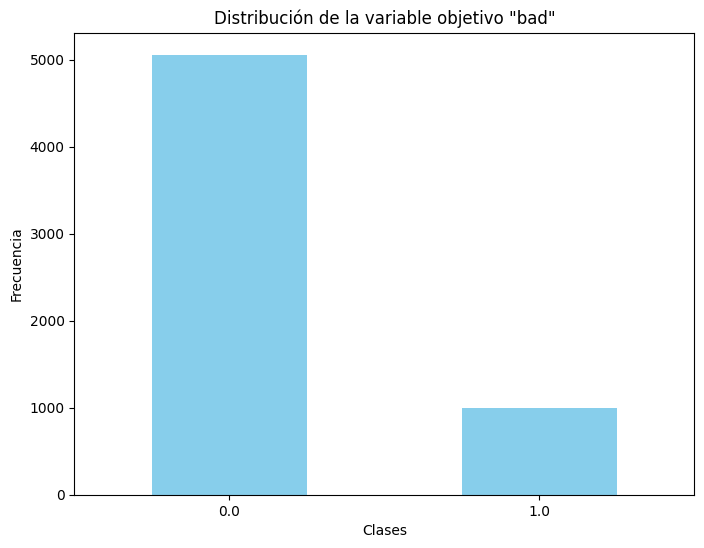

Distribución de la variable objetivo 'bad':
bad
0.0    5059
1.0    1000
Name: count, dtype: int64


In [18]:
bad_distribution = row_data['bad'].value_counts()

plt.figure(figsize=(8, 6))
bad_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribución de la variable objetivo "bad"')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

print("Distribución de la variable objetivo 'bad':")
print(bad_distribution)

### 2.2 Datos faltantes

In [24]:
missing_data = row_data.isna().sum()

print("Datos faltantes por columna:")
print(missing_data)

Datos faltantes por columna:
edad                   0
nro_hijos              0
nro_vehiculos          0
ingreso_bruto          9
ingreso_liquido        0
consumo                0
hipot                  0
comercial              0
disponible             0
dd_aldia_y_menor30     0
dd_impaga_30_90        0
dd_impaga_90_180       0
dd_impaga_180_3anos    0
estado_civil           0
nivel_educacional      0
tiene_propiedades      0
ciclo_vida_small       0
recaudacion_origen     0
bad                    7
dtype: int64


# Eliminamos los registro con Nan en la columna bad

In [92]:
data = row_data.dropna(subset=['bad'])
print(data.shape)


(6059, 19)


## **3. Analisis Exploratorio de datos**


### 3.1 Analisis Univariado

In [93]:
data_group = data.groupby('bad').mean()
display(data_group)

,edad,nro_hijos,nro_vehiculos,ingreso_bruto,ingreso_liquido,consumo,hipot,comercial,disponible,dd_aldia_y_menor30,dd_impaga_30_90,dd_impaga_90_180,dd_impaga_180_3anos,estado_civil,nivel_educacional,tiene_propiedades,ciclo_vida_small,recaudacion_origen
bad,,,,,,,,,,,,,,,,,,
0.0,48.797588,0.823088,0.254793,4.621796e+06,2.057019e+08,1.379224e+07,1.484018e+07,2.477070e+06,1.061071e+07,6.692748e+06,5672.069579,4210.515912,99912.630955,1.642222,1.314094,0.326349,3.095078,1.924293
1.0,47.682000,0.850000,0.204000,4.210377e+06,1.716408e+07,1.454043e+07,7.736395e+06,1.134720e+06,6.498280e+06,5.006985e+06,12204.000000,3918.000000,41862.000000,1.675000,1.104000,0.228000,3.057000,1.842000


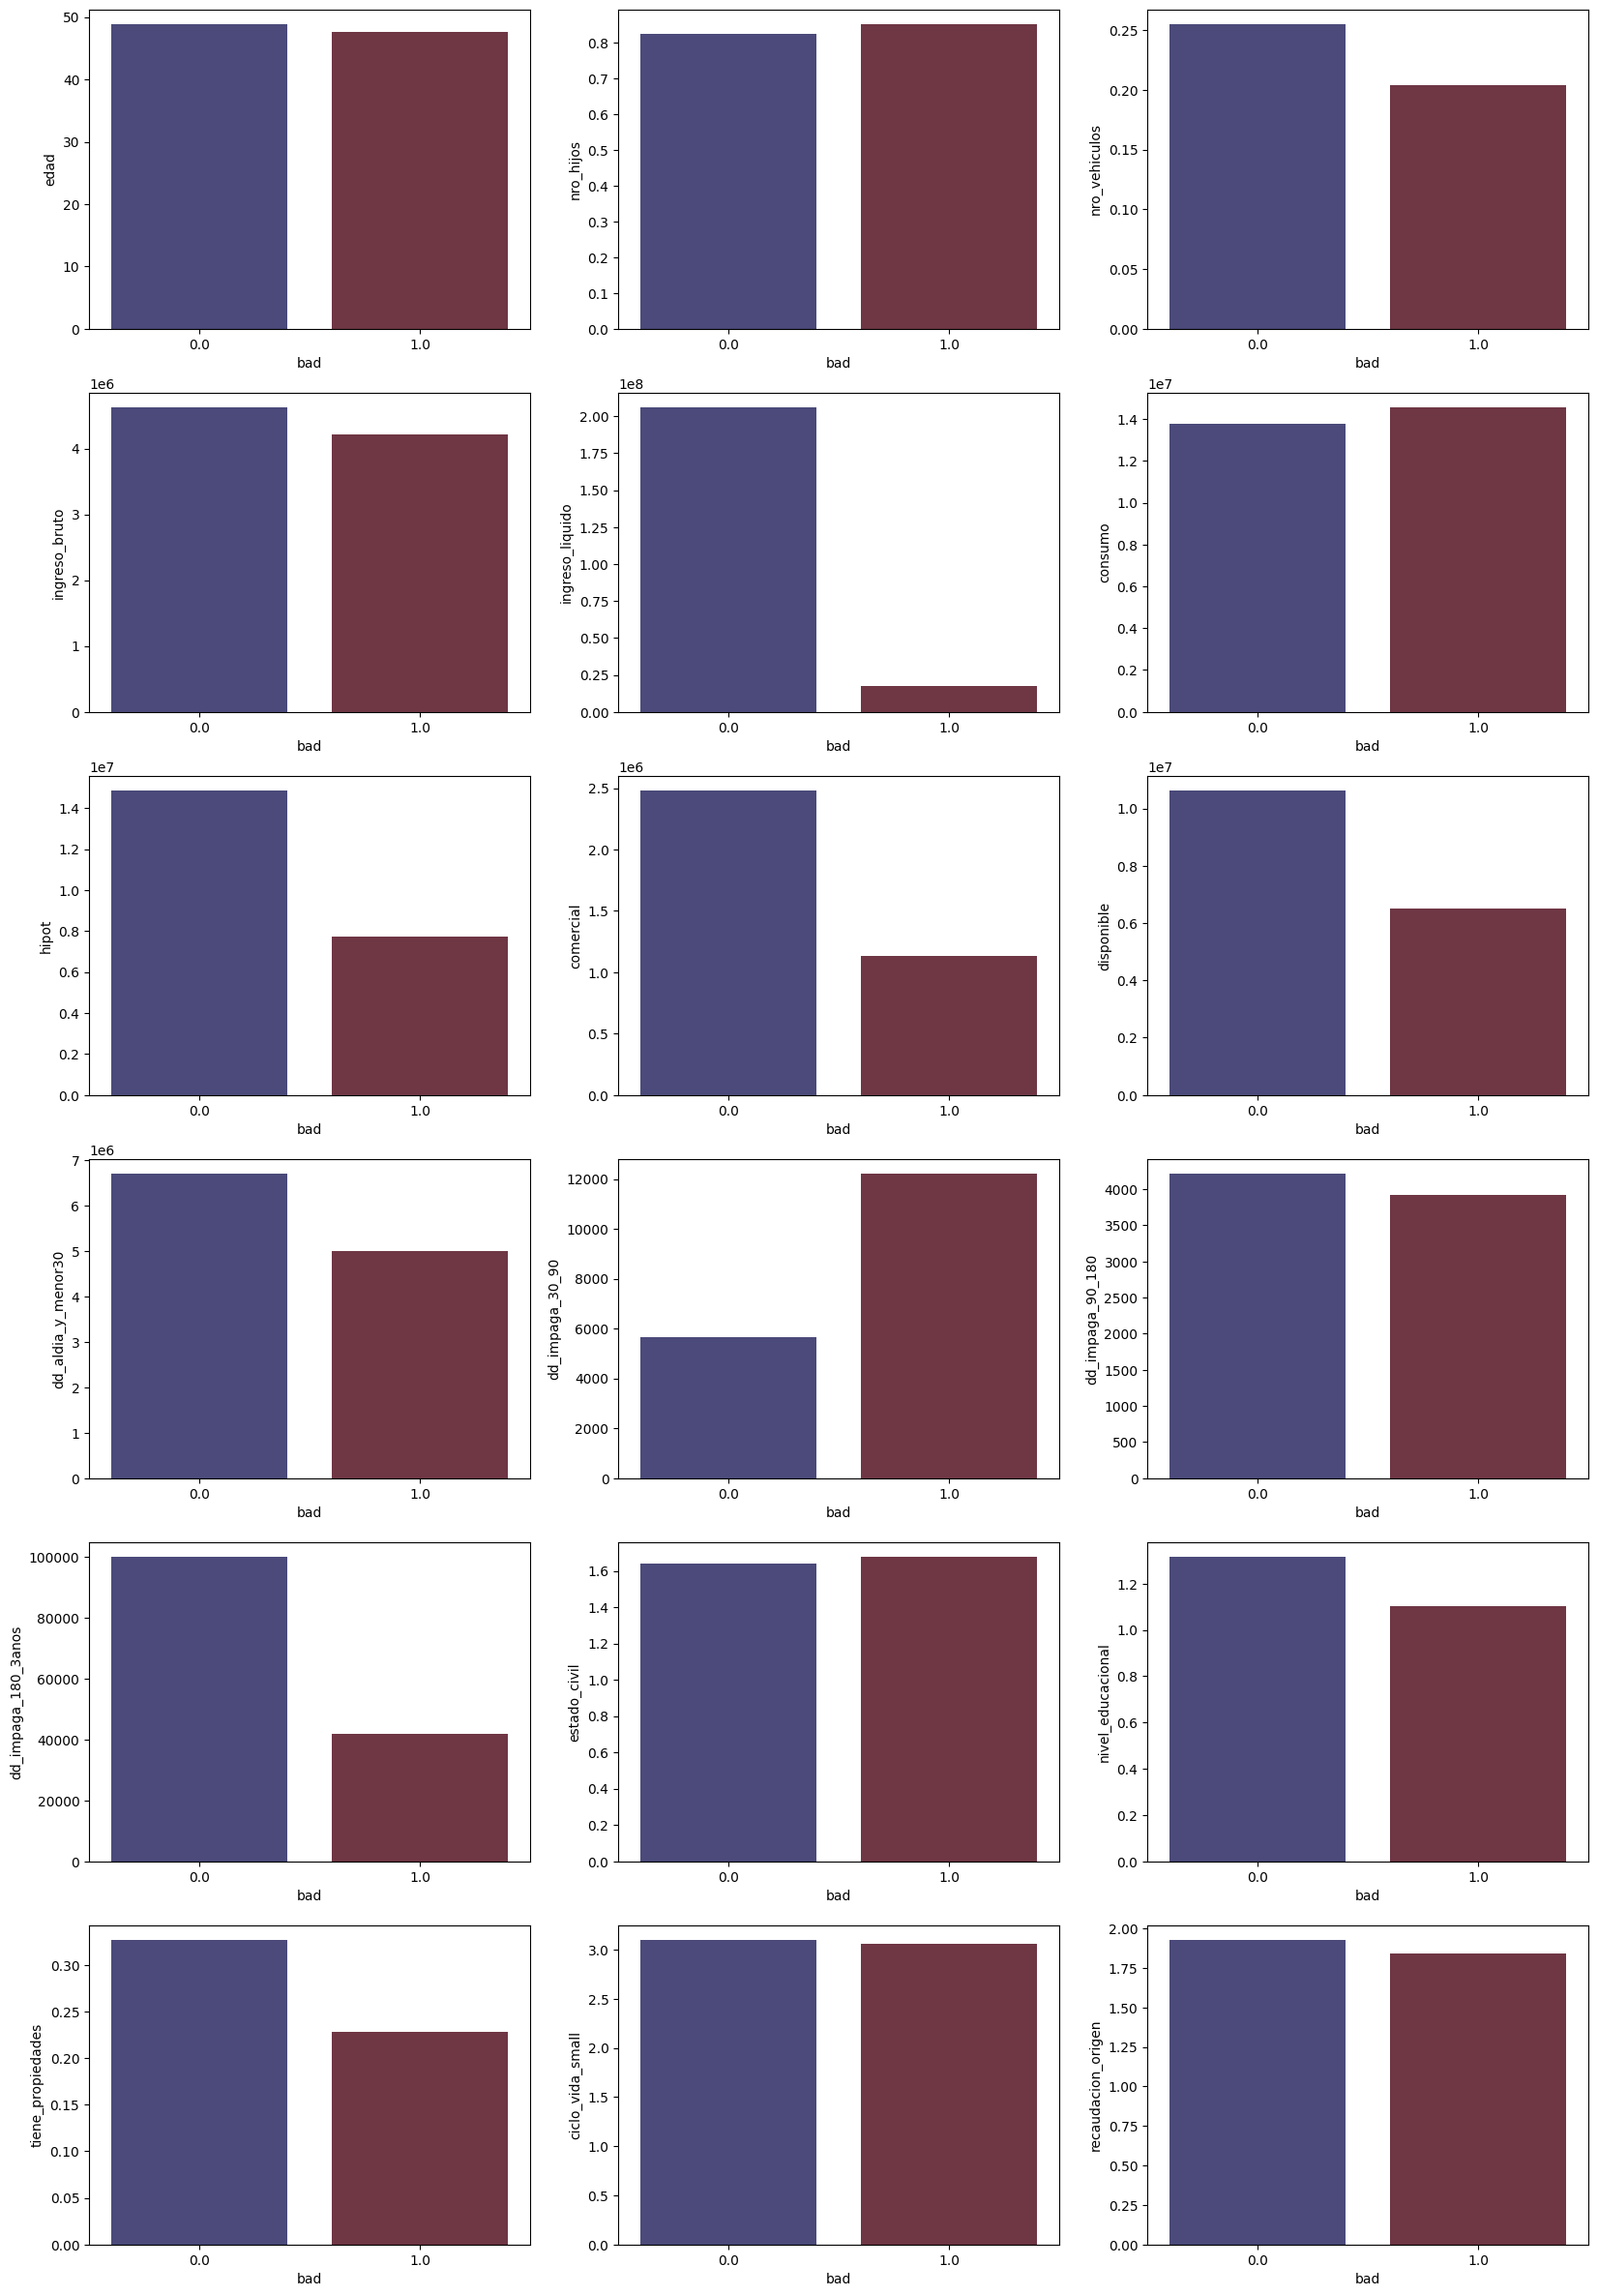

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Se establece las distrubucuón de los subplots
plot_rows,plot_columns=6,3
fig, axes = plt.subplots(plot_rows,plot_columns)

#Se crea la función para calcular la posición de cada figura en el plot
get_coord = lambda i:[int(np.floor(i/plot_columns)),i%plot_columns]

plt.gcf().set_size_inches(20, 5*plot_rows)
for i,col in enumerate(data_group.columns):   
    x,y=get_coord(i)
    sns.barplot(x=data_group.index,
                y=col,
               # order=["bajo","medio","alto"],
                data=data_group,
                ax=axes[x,y],
                palette = 'icefire')

### Analisis por gráfico de cajas

A continuación se van a revisar las por gráfico de cajas la variables

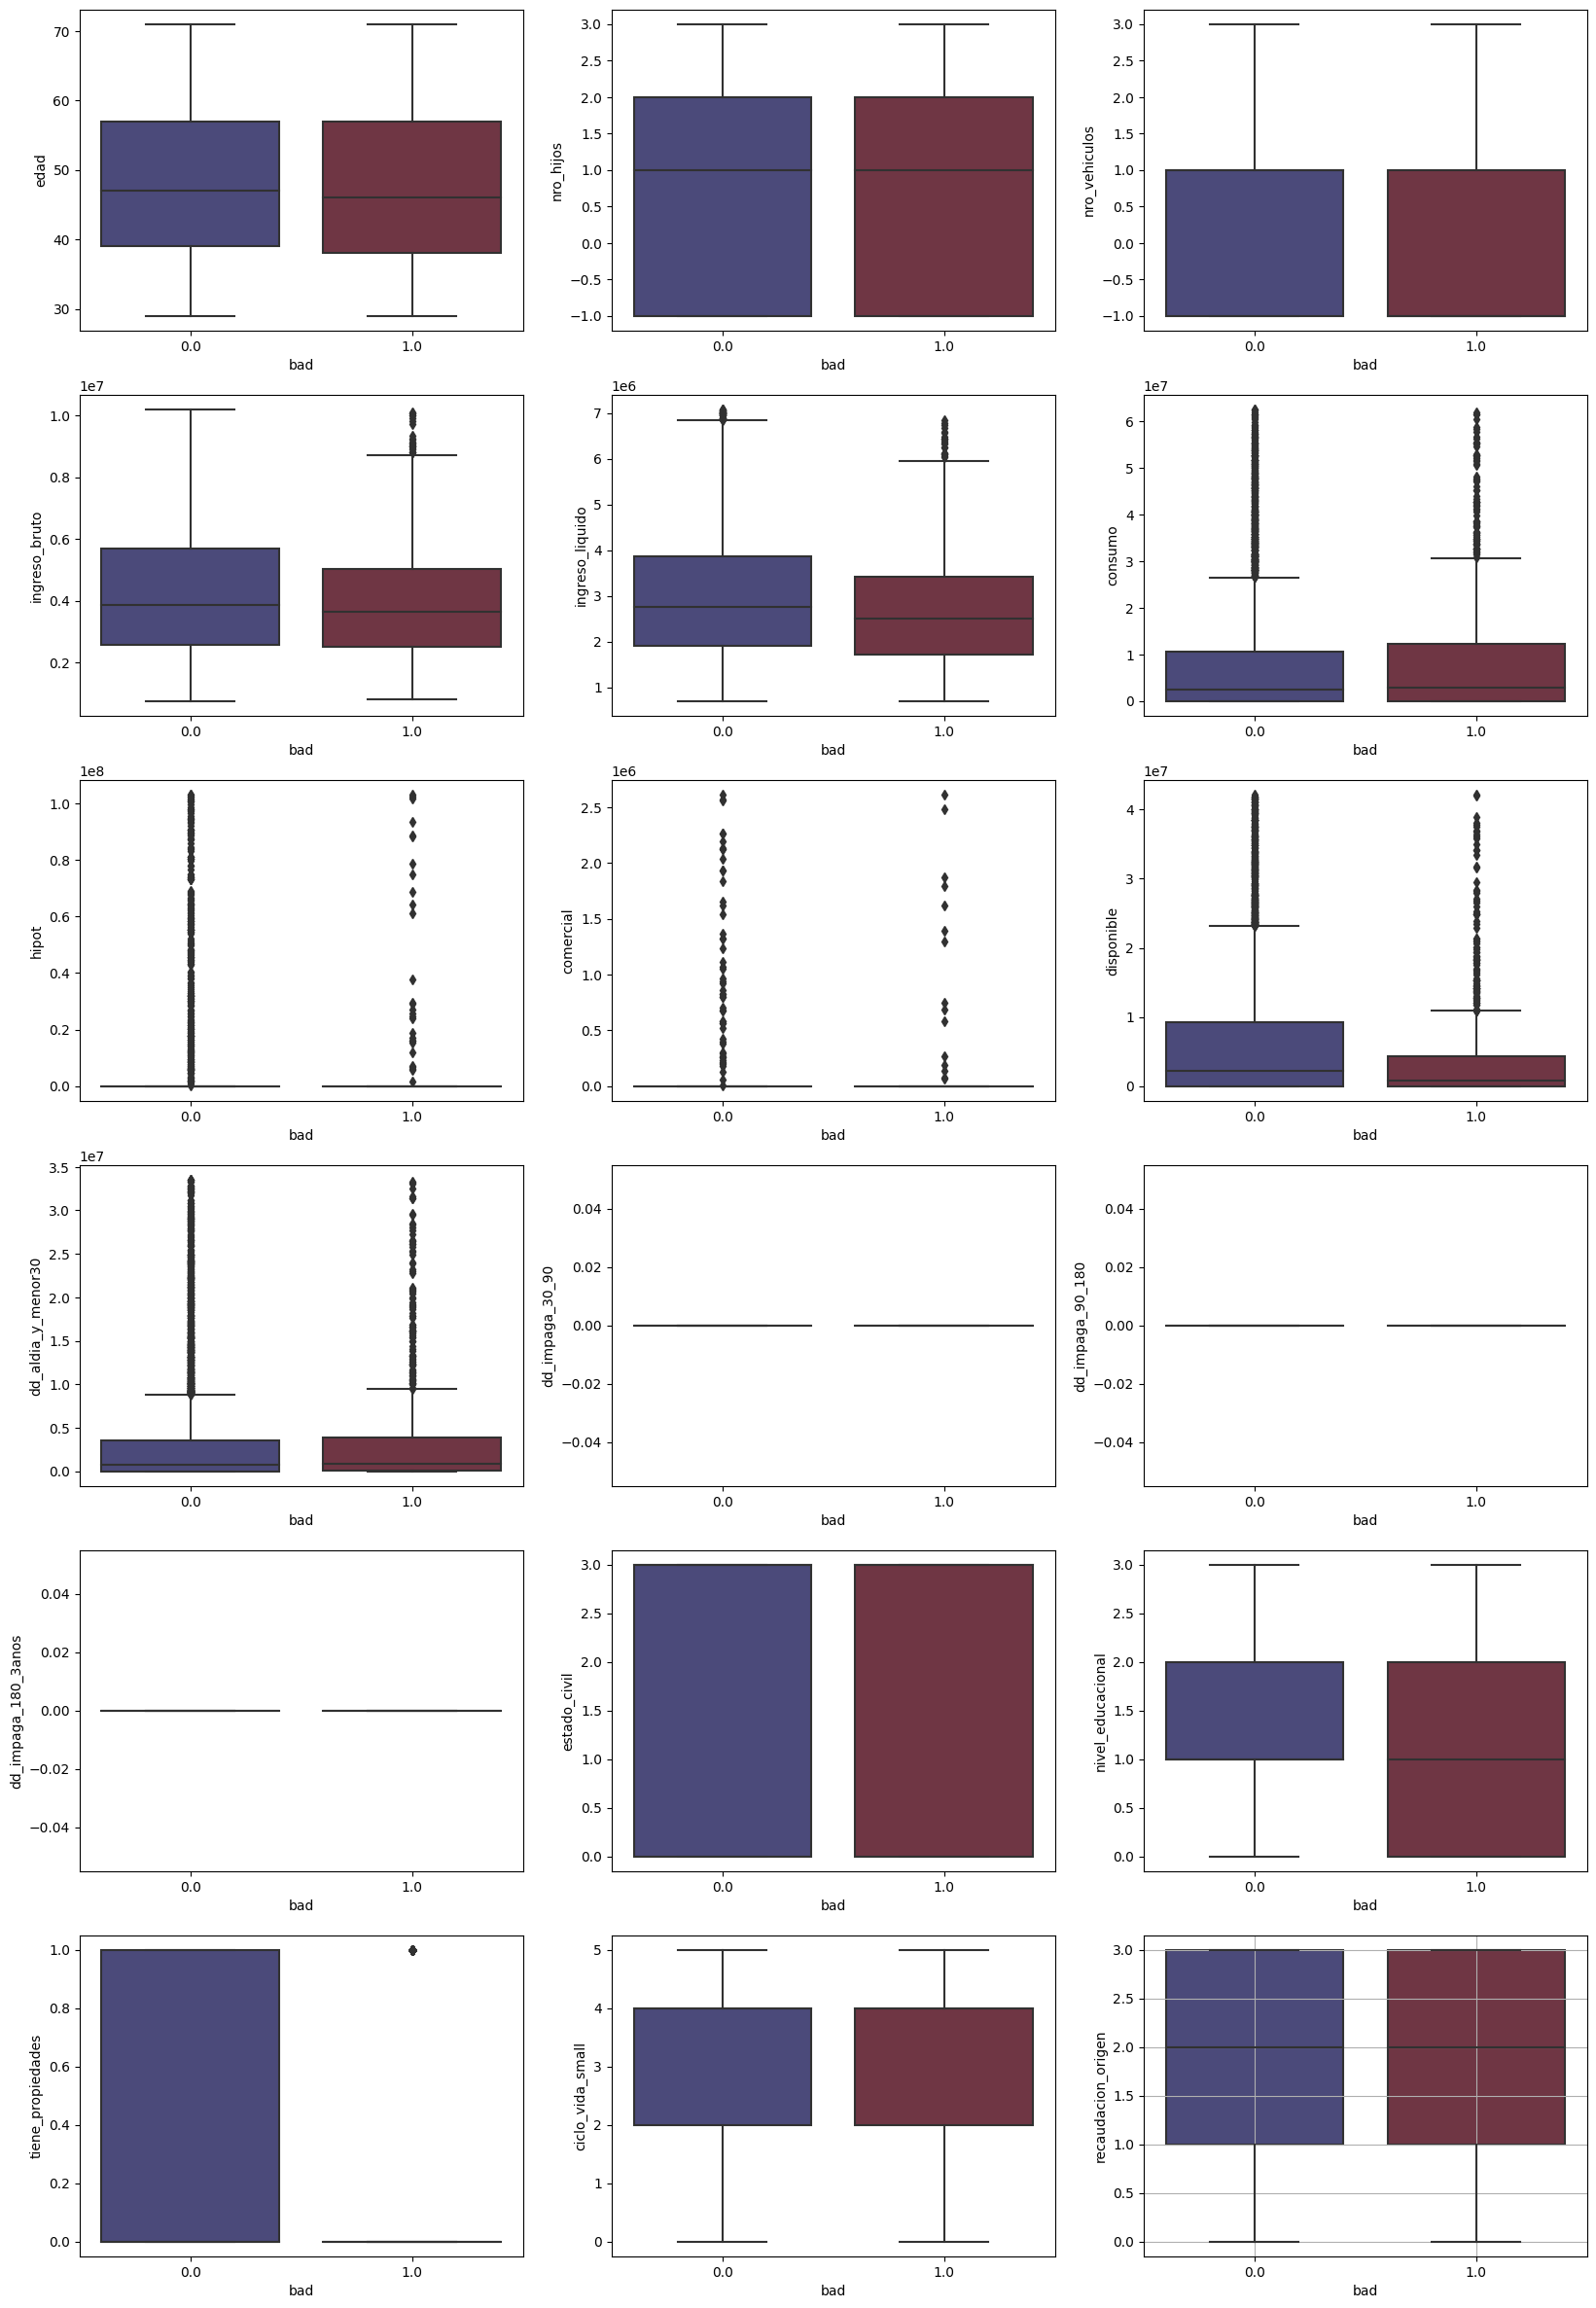

In [35]:
#Se establece las distrubucuón de los subplots
plot_rows,plot_columns=6,3
fig, axes = plt.subplots(plot_rows,plot_columns)

#Se crea la función para calcular la posición de cada figura en el plot
get_coord = lambda i:[int(np.floor(i/plot_columns)),i%plot_columns]

plt.gcf().set_size_inches(20, 5*plot_rows)
for i,col in enumerate(data_group.columns):  
    x,y=get_coord(i)
    #Mascara pera eliminar outliers
    mask= row_data[col].between(row_data[col].quantile(0.05),row_data[col].quantile(0.95))
    #Dataframe de negocios fachada sin outliers
    data_wol=row_data[mask].copy()  
    #Se hace el gráfico
    sns.boxplot(data=data_wol, 
            x='bad',
            y=col,
            ax=axes[x,y],
            palette = 'icefire')
     
plt.grid()
plt.show()

### Anlisis de ditibución y normales de cada variables

### Primer análisis

Visualmentes se puede observar cierta correalción inicial entre la clase y las variables: ingreso_liquido, dd_impaga_90_180, hipot, comercial, dd_impaga_30_90, disponible    

Pero para la selección de atributos realizaremos pruebas estadisticas, para que estos sean seleccionados automaticamente

### 3.2 Analisis Bivariado

In [94]:
data_X= data.iloc[:, :-1]
X_corr=data_X.corr()
display(X_corr)

,edad,nro_hijos,nro_vehiculos,ingreso_bruto,ingreso_liquido,consumo,hipot,comercial,disponible,dd_aldia_y_menor30,dd_impaga_30_90,dd_impaga_90_180,dd_impaga_180_3anos,estado_civil,nivel_educacional,tiene_propiedades,ciclo_vida_small,recaudacion_origen
edad,1.000000,0.379079,0.100263,-0.000353,0.014439,0.064201,0.003250,0.003034,0.129923,0.025269,0.008945,0.008449,0.014113,-0.409654,-0.054427,0.348962,0.155417,0.202127
nro_hijos,0.379079,1.000000,0.101298,0.033016,-0.012481,0.103663,0.035624,0.039050,0.040260,0.080198,0.062287,0.022012,0.038397,-0.356265,-0.130745,0.207732,0.080690,-0.020865
nro_vehiculos,0.100263,0.101298,1.000000,0.128628,-0.007903,0.133939,0.087276,0.026101,0.129089,0.131104,0.015358,0.001143,-0.016931,-0.118286,0.049140,0.156406,-0.022436,0.017971
ingreso_bruto,-0.000353,0.033016,0.128628,1.000000,-0.009221,0.203773,0.122741,0.262757,0.491805,0.239559,0.039626,-0.004176,-0.009348,-0.053895,0.166139,0.021998,0.005467,-0.234937
ingreso_liquido,0.014439,-0.012481,-0.007903,-0.009221,1.000000,-0.004895,-0.003845,-0.001800,-0.005525,0.000500,-0.001831,-0.000966,-0.001482,-0.019362,-0.017539,0.000176,-0.015141,0.007522
consumo,0.064201,0.103663,0.133939,0.203773,-0.004895,1.000000,0.233670,0.219254,0.245253,0.592074,0.142663,0.043834,0.183663,-0.057448,0.065593,0.113078,-0.050461,0.009809
hipot,0.003250,0.035624,0.087276,0.122741,-0.003845,0.233670,1.000000,0.099537,0.229857,0.840748,0.040899,0.009413,-0.006755,-0.021161,0.086715,0.205951,-0.077315,0.060504
comercial,0.003034,0.039050,0.026101,0.262757,-0.001800,0.219254,0.099537,1.000000,0.292346,0.395323,0.076209,0.008993,-0.004207,-0.020761,0.034888,0.092572,-0.020726,0.009250
disponible,0.129923,0.040260,0.129089,0.491805,-0.005525,0.245253,0.229857,0.292346,1.000000,0.344735,0.030767,-0.015768,-0.020479,-0.048866,0.114560,0.162837,-0.016902,0.155788
dd_aldia_y_menor30,0.025269,0.080198,0.131104,0.239559,0.000500,0.592074,0.840748,0.395323,0.344735,1.000000,0.091651,0.015316,-0.000469,-0.042467,0.103260,0.242040,-0.083591,0.057163


In [95]:
X_corr.style.background_gradient(cmap=plt.get_cmap('RdYlGn'), axis=1)

,edad,nro_hijos,nro_vehiculos,ingreso_bruto,ingreso_liquido,consumo,hipot,comercial,disponible,dd_aldia_y_menor30,dd_impaga_30_90,dd_impaga_90_180,dd_impaga_180_3anos,estado_civil,nivel_educacional,tiene_propiedades,ciclo_vida_small,recaudacion_origen
edad,1.000000,0.379079,0.100263,-0.000353,0.014439,0.064201,0.003250,0.003034,0.129923,0.025269,0.008945,0.008449,0.014113,-0.409654,-0.054427,0.348962,0.155417,0.202127
nro_hijos,0.379079,1.000000,0.101298,0.033016,-0.012481,0.103663,0.035624,0.039050,0.040260,0.080198,0.062287,0.022012,0.038397,-0.356265,-0.130745,0.207732,0.080690,-0.020865
nro_vehiculos,0.100263,0.101298,1.000000,0.128628,-0.007903,0.133939,0.087276,0.026101,0.129089,0.131104,0.015358,0.001143,-0.016931,-0.118286,0.049140,0.156406,-0.022436,0.017971
ingreso_bruto,-0.000353,0.033016,0.128628,1.000000,-0.009221,0.203773,0.122741,0.262757,0.491805,0.239559,0.039626,-0.004176,-0.009348,-0.053895,0.166139,0.021998,0.005467,-0.234937
ingreso_liquido,0.014439,-0.012481,-0.007903,-0.009221,1.000000,-0.004895,-0.003845,-0.001800,-0.005525,0.000500,-0.001831,-0.000966,-0.001482,-0.019362,-0.017539,0.000176,-0.015141,0.007522
consumo,0.064201,0.103663,0.133939,0.203773,-0.004895,1.000000,0.233670,0.219254,0.245253,0.592074,0.142663,0.043834,0.183663,-0.057448,0.065593,0.113078,-0.050461,0.009809
hipot,0.003250,0.035624,0.087276,0.122741,-0.003845,0.233670,1.000000,0.099537,0.229857,0.840748,0.040899,0.009413,-0.006755,-0.021161,0.086715,0.205951,-0.077315,0.060504
comercial,0.003034,0.039050,0.026101,0.262757,-0.001800,0.219254,0.099537,1.000000,0.292346,0.395323,0.076209,0.008993,-0.004207,-0.020761,0.034888,0.092572,-0.020726,0.009250
disponible,0.129923,0.040260,0.129089,0.491805,-0.005525,0.245253,0.229857,0.292346,1.000000,0.344735,0.030767,-0.015768,-0.020479,-0.048866,0.114560,0.162837,-0.016902,0.155788
dd_aldia_y_menor30,0.025269,0.080198,0.131104,0.239559,0.000500,0.592074,0.840748,0.395323,0.344735,1.000000,0.091651,0.015316,-0.000469,-0.042467,0.103260,0.242040,-0.083591,0.057163


En una ánalisis inicial se observa correlación entre dd_aldia_y_menor30 e hipot. Para no tener una medición sesgada por la presencia de dos variables similares que tengam doble incidencia sobre el modelo la variable dd_aldia_y_menor30 es candidata de salir del análisis


### 3.3 Otros

## **4. Outliers, missing y correlaciones**

### 4.1 Outliers

Queda péndiente por tiempo, para esto tenemos varías alternativas, que es importante evaluar.

### 4.2 Missing

In [ ]:
#Ya se eliminaron en la primera parte

### 4.3 Correlaciones

In [ ]:
#Se realiza en el siguiente capitulo

## **5. Transformación y selección de variables**

A continuación se creará una función que resiva el dataset y se encargue de hacer la selección de atributos de forma automátova mediante pruebas estadisticas.

In [68]:
def seleccionAtributos(data):
    # Selección de atributos
    input_columns = data.columns
    attributes = data.columns[:-1]
    X_data = data[attributes].values
    alpha = 0.01 # nivel de confianza del 99%
    h_norm = np.zeros(X_data.shape[1])

    # Establecer el tipo de distribución que se sigue
    for i in range(0, X_data.shape[1]):
        _, pvalue = kstest(X_data[:, i], 'norm')    
        # Contraste de hipótesis
        if pvalue<=alpha:
            h_norm[i] = 0 # Los datos NO siguen una distribución normal N(0,1)
        else:
            h_norm[i] = 1 # Los datos SÍ siguen una distribución normal N(0,1)

    norm_columns = h_norm
    print('0: no normal  ---- 1: sí normal: ', h_norm)

    #Capacidad discriminativa
    positiveClass = data[data.bad == 1]  
    positiveClass = positiveClass.drop(['bad'], axis=1)
    positiveClass = positiveClass.values
    positiveShape = positiveClass.shape

    negativeClass = data[data.bad == 0]  
    negativeClass = negativeClass.drop(['bad'], axis=1)
    negativeClass = negativeClass.values
    negativeShape = negativeClass.shape

    X = data
    X = X.drop(['bad'], axis=1)

    h = np.zeros(X.shape[1])
    h_disc = np.zeros(X.shape[1])

    # Eliminar caraterisiticas dependientes
    for i in range(0, X.shape[1]):
        if h_norm[i] == 0: # no es normal --> comparación de medianas (mannwhitneyu)
            _, pvalue = mannwhitneyu(positiveClass[:,i], negativeClass[:,i])
        else: # sí es normal --> comparación de medias (ttest_ind)
            _, pvalue = ttest_ind(positiveClass[:,i], negativeClass[:,i])
        
        # contraste de hipótesis, estudiar el poder discriminatorio de las características
        # H0: independencia entre la característica y la clase
        if pvalue<=alpha:
            h_disc[i] = 1 # Se rechaza la H0 y, por tanto, asumimos la dependencia entre la característica y la clase
        else:
            h_disc[i] = 0 # No hay evidencia para rechazar la H0 y, por tanto, asumimos que la caract. y la clase son independientes

    print('0: no discrimna, 1: sí discrimina', h_disc)

    id_no_disc = np.where(h_disc==0)
    ticks = np.delete(attributes, id_no_disc[0])
    discAttibutes = ticks
    noDiscAttibutes = np.setdiff1d(attributes, ticks)

    #Eliminar caracteristicas no discriminatorias
    X = X[ticks]
    outputColums = X.columns
    print('outputColums: ',outputColums)
    x_shape = X.shape

    details = {  "input_shape":data.shape
                    , "input_columns":input_columns
                    , "norm_columns":norm_columns
                    , "positive_Shape":positiveShape
                    , "negative_Shape":negativeShape
                    , "discAttibutes":discAttibutes
                    , "noDiscAttibutes":noDiscAttibutes
                    , "output_colums":outputColums
                    , "x_shape":x_shape}

    return X, details


#### Imputación de valores,

Para esto vamos a realizar imputación con la estrategía de medias. Como no tenemos resultados vacios en la columna Y lo vamos a hacer sobre todos los datos

In [100]:
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy='mean')
imputer.fit(data)

# Transformar los datos de entrenamiento y prueba
data_imputed = pd.DataFrame(imputer.transform(data), columns=data.columns)


In [110]:
X, detalles = seleccionAtributos(data_imputed)

0: no normal  ---- 1: sí normal:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0: no discrimna, 1: sí discrimina [0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
outputColums:  Index(['ingreso_bruto', 'ingreso_liquido', 'hipot', 'disponible',
       'dd_impaga_30_90', 'nivel_educacional', 'tiene_propiedades'],
      dtype='object')


No se obtubieron buenos resultados con esta clasificación por lo cual se descarta y se trabnaja con el dataset completo

In [125]:
X= data_imputed

In [102]:
display(detalles)

{'input_shape': (6059, 19),
 'input_columns': Index(['edad', 'nro_hijos', 'nro_vehiculos', 'ingreso_bruto',
        'ingreso_liquido', 'consumo', 'hipot', 'comercial', 'disponible',
        'dd_aldia_y_menor30', 'dd_impaga_30_90', 'dd_impaga_90_180',
        'dd_impaga_180_3anos', 'estado_civil', 'nivel_educacional',
        'tiene_propiedades', 'ciclo_vida_small', 'recaudacion_origen', 'bad'],
       dtype='object'),
 'norm_columns': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'positive_Shape': (1000, 18),
 'negative_Shape': (5059, 18),
 'discAttibutes': Index(['ingreso_bruto', 'ingreso_liquido', 'hipot', 'disponible',
        'dd_impaga_30_90', 'nivel_educacional', 'tiene_propiedades'],
       dtype='object'),
 'noDiscAttibutes': array(['ciclo_vida_small', 'comercial', 'consumo', 'dd_aldia_y_menor30',
        'dd_impaga_180_3anos', 'dd_impaga_90_180', 'edad', 'estado_civil',
        'nro_hijos', 'nro_vehiculos', 'recaudacion_origen'], dty

In [131]:
X.sample(10)

,edad,nro_hijos,nro_vehiculos,ingreso_bruto,ingreso_liquido,consumo,hipot,comercial,disponible,dd_aldia_y_menor30,dd_impaga_30_90,dd_impaga_90_180,dd_impaga_180_3anos,estado_civil,nivel_educacional,tiene_propiedades,ciclo_vida_small,recaudacion_origen,bad
5951,31.0,-1.0,-1.0,3745330.0,3440745.0,25885000.0,0.0,0.0,3875000.0,5177000.0,0.0,0.0,0.0,3.0,1.0,0.0,5.0,2.0,0.0
3685,51.0,-1.0,1.0,3047445.0,3047445.0,11825000.0,0.0,0.0,22170000.0,2365000.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,3.0,0.0
4836,50.0,2.0,-1.0,2611450.0,980160.0,4765000.0,0.0,40105000.0,3660000.0,24372000.0,0.0,0.0,0.0,3.0,1.0,0.0,4.0,1.0,0.0
1461,34.0,-1.0,1.0,4369550.0,3737660.0,1365000.0,0.0,0.0,1185000.0,273000.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,1.0
66,38.0,2.0,1.0,8888940.0,3435370.0,510.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0,1.0,0.0
4561,44.0,2.0,-1.0,6655590.0,5131805.0,18379280.0,0.0,4290000.0,0.0,4533856.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
629,64.0,1.0,-1.0,5178715.0,4766230.0,77990000.0,0.0,0.0,4250000.0,15598000.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,1.0,0.0
3066,48.0,3.0,2.0,5130460.0,3049480.0,5860000.0,0.0,0.0,3610000.0,1172000.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,1.0
4350,46.0,-1.0,2.0,3581525.0,2210160.0,2967715.0,0.0,0.0,0.0,593543.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,1.0,0.0
1487,35.0,-1.0,-1.0,5894495.0,3407410.0,0.0,0.0,0.0,755000.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,5.0,1.0,0.0


El algoritmo ha seleccionado solo 7 variables, la cuales considera discriminativas. Es posible hacer un análisis más completo, pero por tiempo no es posible, así que vamos a tomar estas 6 variables sugeridas

###Normalización.

Como vemos que la mayoría de de atributos no son normales, entonces vamos a realizar un proceso de Normalización y no estandartización de los atributos

In [126]:
scaler = MinMaxScaler()
scaler.fit(X)

X_normalize = pd.DataFrame(scaler.transform(X))


## **6. Definiciones de Negocio**

## **7. Modelación**

In [127]:
y =  data.iloc[:, -1]

#Creación de la partición interna

X_train, X_test, y_train, y_test = train_test_split(X_normalize, y, test_size=0.2, random_state=42)

In [128]:
missing_data = y_test.isna().sum()

# Mostrar los resultados
print("Datos faltantes por columna:")
print(missing_data)

Datos faltantes por columna:
0


### 7.1 Modelo(s)

#### Boosting 

In [129]:
# Crear el modelo de Gradient Boosting
modelo_gb = GradientBoostingClassifier()

#Balanceo de clases
clase_positiva = 1
clase_negativa = 0
pesos_muestra = [1.0 / len(y_train) if clase == clase_positiva else 1.0 / len(y_train) for clase in y_train]


# Entrenar el modelo
modelo_gb.fit(X_train, y_train, sample_weight=pesos_muestra)

# Predecir en el conjunto de prueba
Y_pred = modelo_gb.predict(X_test)

# Calcular la precisión del modelo
precision = accuracy_score(y_test, Y_pred)
print("Precisión del modelo de Gradient Boosting:", precision)

Precisión del modelo de Gradient Boosting: 1.0


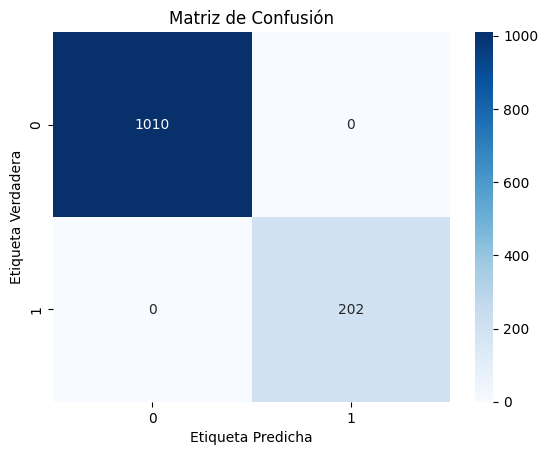

In [130]:
conf_matrix = confusion_matrix(y_test, Y_pred)
# Visualizar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

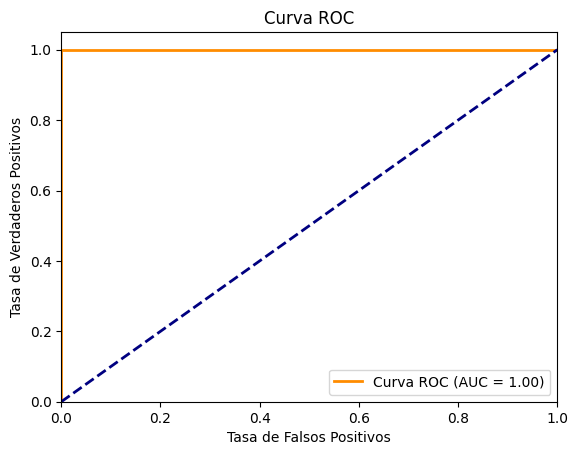

In [134]:
# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_test, Y_pred)
roc_auc = auc(fpr, tpr)
f_auc = '%0.2f' % roc_auc

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()



#### Validación cruzada

Como el algoritmo nos esta dando valores perfectos puede ser un muiestra de que estpa sobre entrenado, por tal motivo vamos a probar la generación de validaciones cruzadas

In [141]:
from sklearn.model_selection import cross_val_score

# Supongamos que tienes tus características en X y tus etiquetas en y

# Crear un modelo de Gradient Boosting Classifier
modelo_gb = GradientBoostingClassifier()

# Realizar validación cruzada
puntuaciones = cross_val_score(modelo_gb, X_train, y_train, cv=5)  # cv=5 para realizar una validación cruzada de 5 veces

# Imprimir las puntuaciones de validación cruzada
print("Puntuaciones de validación cruzada:", puntuaciones)

# Calcular y mostrar la puntuación media y la desviación estándar de las puntuaciones
print("Precisión media: %0.2f (+/- %0.2f)" % (puntuaciones.mean(), puntuaciones.std() * 2))

Puntuaciones de validación cruzada: [1. 1. 1. 1. 1.]
Precisión media: 1.00 (+/- 0.00)


Con la validación cruzada obtenemos los mismo resultados, por tal motivo seguimos con este algoritmo como base.

### Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier()

#Balanceo de clases
clase_positiva = 1
clase_negativa = 0
pesos_muestra = [1.0 / len(y_train) if clase == clase_positiva else 1.0 / len(y_train) for clase in y_train]


# Entrenar el modelo
modelo_rf.fit(X_train, y_train, sample_weight=pesos_muestra)

# Predecir en el conjunto de prueba
predicciones = modelo_rf.predict(X_test)

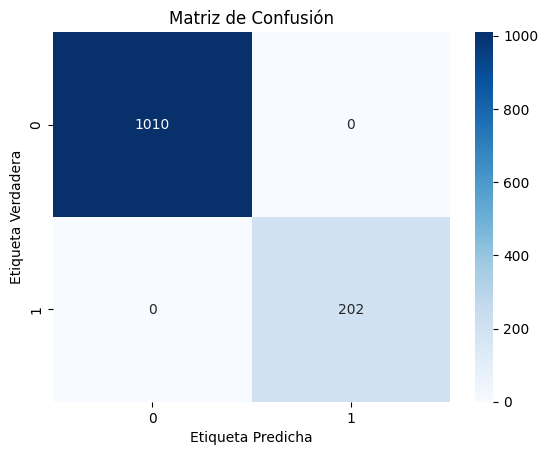

In [137]:
conf_matrix = confusion_matrix(y_test, Y_pred)
# Visualizar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

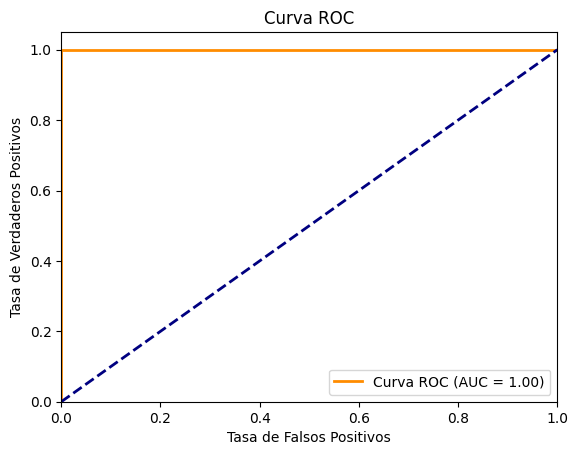

In [138]:
# Calcular la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y_test, Y_pred)
roc_auc = auc(fpr, tpr)
f_auc = '%0.2f' % roc_auc

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## **8. Conclusiones**

Ambos algoritmos presentan muy buenos resultados, es tradicional en ejercicios de aprendizaje supervizado trabjar con un algoritmo base, en este caso fue el algoritmo de Random Forest y un algoritmo de punta, para este caso escogimos boosting la cual combina multiples modelos para construir un modelo más robusto. Ambas técnicas nos dieron buenos resultados en los cuales es importante hacer una validación externa, con el fin de descartar sobre entrenamiento. Escogería el modelo de boosting por ser un algortimo más potente.

In [142]:


# Guardar el modelo en un archivo
joblib.dump(modelo_gb, 'modelo_gb.pkl')

['modelo_gb.pkl']